# Fractional Brownian motion

In [3]:
import warnings
warnings.filterwarnings('ignore')

#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# conda install matplotlib path scipy statsmodels seaborn 

In [10]:
# pip install palettable tqdm

In [8]:
# Standard Libraries
import sys
import os
import path

# Third party libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm

# Figures
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker
import palettable
import seaborn as sns

In [19]:
## Local Functions
src_dir = os.path.abspath(os.path.join(os.pardir, 'src'))
sys.path.append(src_dir)

from utils import *
from stats import *
from plots import *

src_dir = os.path.abspath(os.path.join(os.pardir, 'combmodel'))
sys.path.append(src_dir)
from combmodel import *

# Fractional Brownian motion

In [16]:
generate_noise(hurstx=0.01,hursty=0.99,tmax=5)

(array([-0.13592058,  0.2187307 ,  0.21764903,  0.2029542 , -1.48543505]),
 array([-0.29290523, -0.30217054, -0.22682417, -0.25869089, -0.39384616]))

In [17]:
langevin_fbn(x0=0,y0=0,betax=1,betay=1,hurstx=0.05,hursty=0.95,tmax=10,disable_tqdm=True)

(array([ 0.        ,  0.18965772,  0.98701696, -0.04895207, -0.70422128,
        -0.63351615, -1.8885845 ,  0.79547242,  0.45281022,  0.09393627]),
 array([ 0.        , -0.09428351, -0.1200607 , -0.14642927, -0.14260216,
        -0.10855471, -0.09201696, -0.01436433,  0.03240142,  0.17312892]))

Text(0, 0.5, 'Position, $y(t)$')

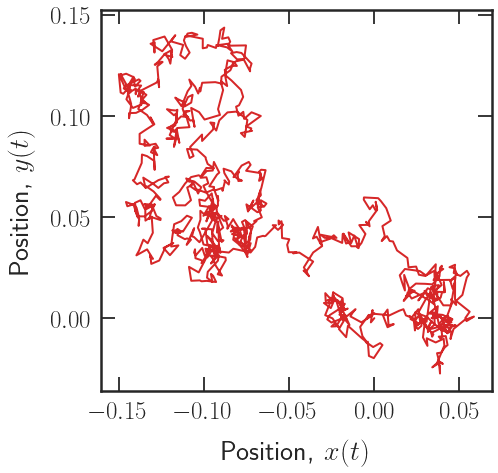

In [20]:
x,y=langevin_fbn(0,0,0.1,0.1,0.5,0.5,10**3,disable_tqdm=True)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1,ratio=1))
ax.plot(x,y,color='#D62728',markersize=0,linewidth=2)
ax.set_xlabel(r'Position, $x(t)$')
ax.set_ylabel(r'Position, $y(t)$')

In [21]:
x0,y0=0,0

x_plane=[]
y_plane=[]
for i in tqdm(range(0,10**3)):
    xi,yi=langevin_fbn(0,0,0.1,0.1,0.5,0.5,10**3,disable_tqdm=True)
    x_plane.append(xi)
    y_plane.append(yi)
x_plane=np.array(x_plane)
y_plane=np.array(y_plane)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1365.27it/s]


Text(0, 0.5, 'Position, $y(t)$')

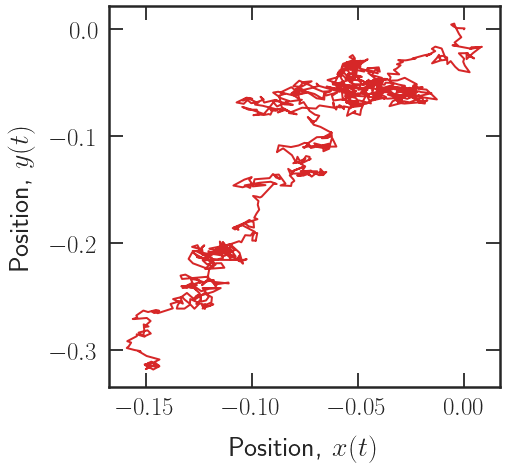

In [22]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1,ratio=1))
ax.plot(x_plane[0],y_plane[0],color='#D62728',markersize=0,linewidth=2)
ax.set_xlabel(r'Position, $x(t)$')
ax.set_ylabel(r'Position, $y(t)$')

In [23]:
t=np.arange(0,len(x_plane[0]))[:]
variance_x=np.var(x_plane,axis=0)[:]
variance_y=np.var(y_plane,axis=0)[:]
params_x=power_law_fit(np.log(t)[1:10**2],np.log(variance_x)[1:10**2])
params_y=power_law_fit(np.log(t)[1:10**2],np.log(variance_y)[1:10**2])
print(params_x,params_y)

[-11.55545994   1.01932553] [-11.45286867   0.98246622]


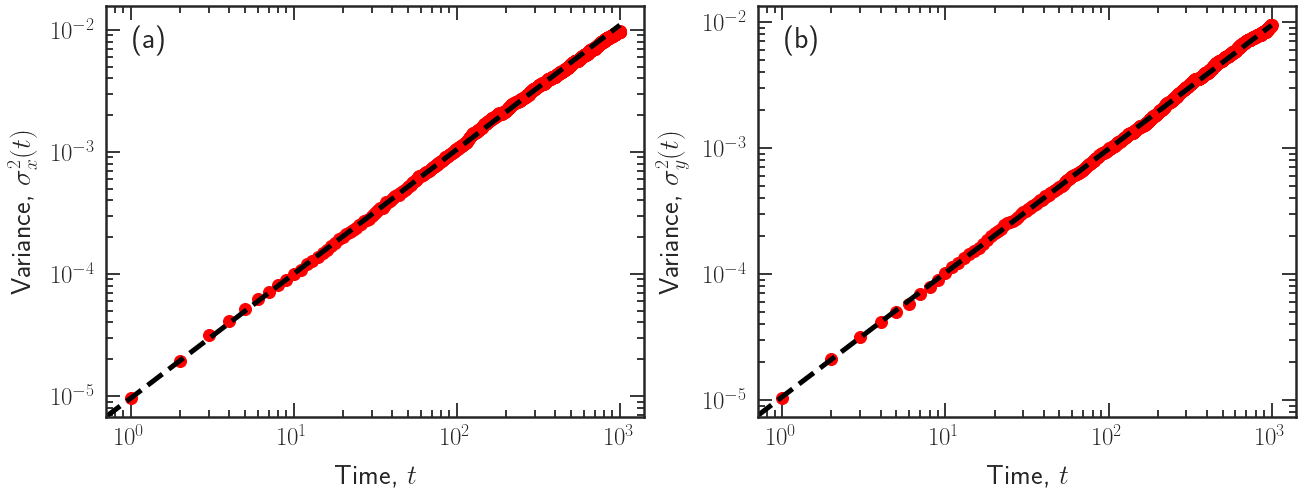

In [24]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nx=2, ny=1, scale=1))

ax=axs.flatten()[0]
   
ax.loglog(t,variance_x,'o',color='red',markersize=12)
ax.loglog(t,power_law_function(t,params_x),'k--')
ax.set_ylabel(r'Variance, $\sigma_x^2(t)$')
ax.set_xlabel(r'Time, $t$')

ax=axs.flatten()[1]
   
ax.loglog(t,variance_y,'o',color='red',markersize=12)
ax.loglog(t,power_law_function(t,params_y),'k--')

ax.set_ylabel(r'Variance, $\sigma_y^2(t)$')
ax.set_xlabel(r'Time, $t$')
label_panels(axs)
plt.tight_layout()

In [25]:
normalized_x,normalized_y=normalize_all_trajectories(x_plane,y_plane)

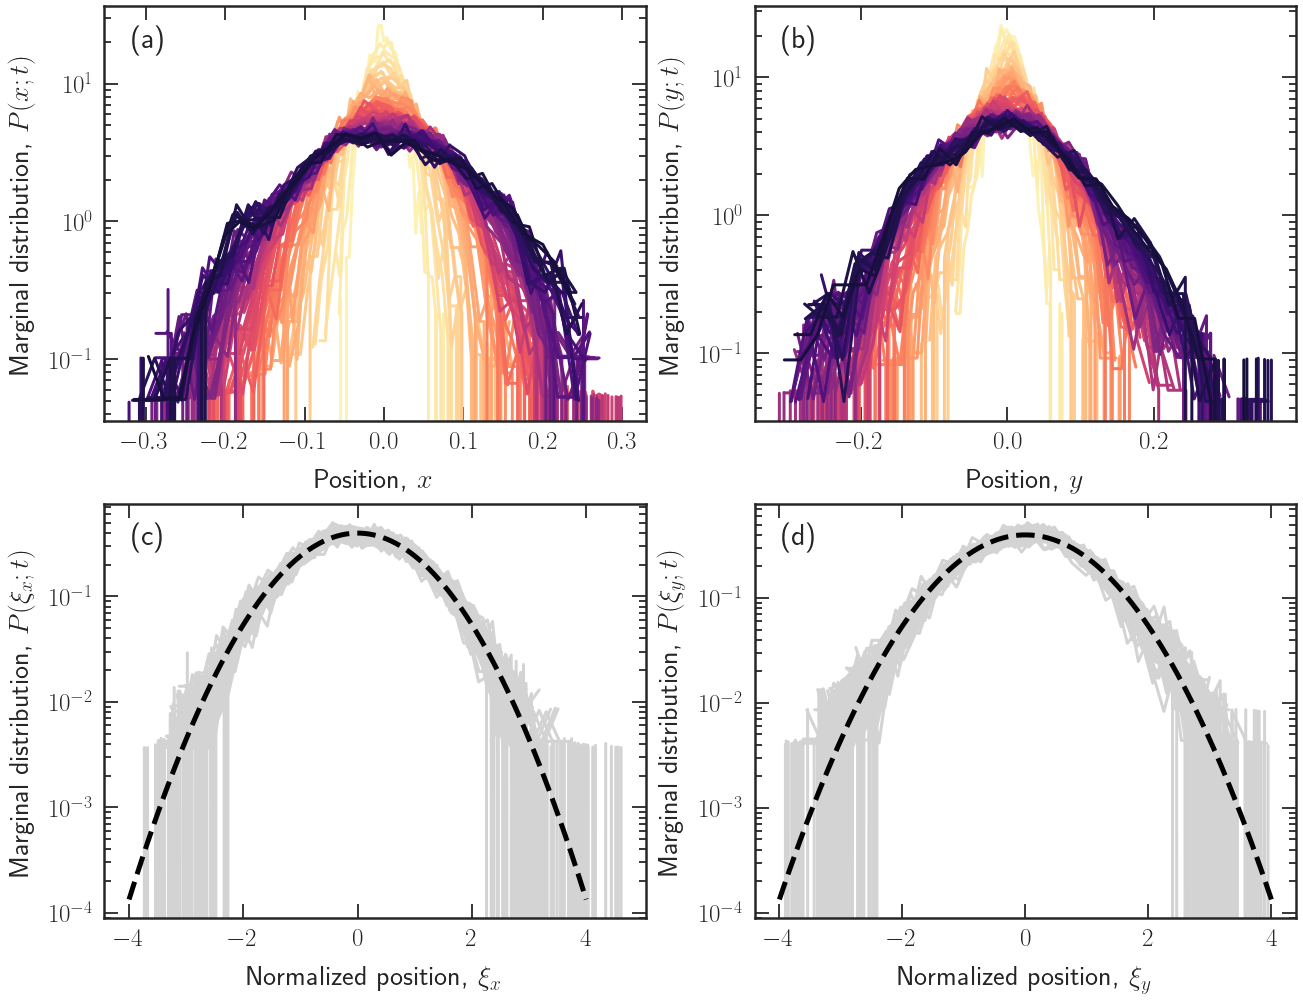

In [26]:
t_interval=10
t_min=30
t_max=1000
colormap = plt.cm.magma_r
colors=[colormap(i) for i in np.linspace(0, 0.9,t_max)]

f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))

ax=axs.flatten()[0]
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(x_plane[::,t])
    ax.plot(bins,densities,color=colors[t],linewidth=3,)

ax.set_yscale('log')
ax.set_xlabel(r'Position, $x$')
ax.set_ylabel(r'Marginal distribution, $P(x;t)$')

ax=axs.flatten()[1]
   
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(y_plane[::,t])
    ax.plot(bins,densities,color=colors[t],linewidth=3)
    
ax.set_yscale('log')
ax.set_xlabel(r'Position, $y$')
ax.set_ylabel(r'Marginal distribution, $P(y;t)$')

ax=axs.flatten()[2]
   
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_x[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)

r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r, 0, 1),'k--')

ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_x$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_x;t)$')

ax=axs.flatten()[3]
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_y[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)

r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r,0,1),'k--')
ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_y$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_y;t)$')

label_panels(axs)
f.tight_layout()


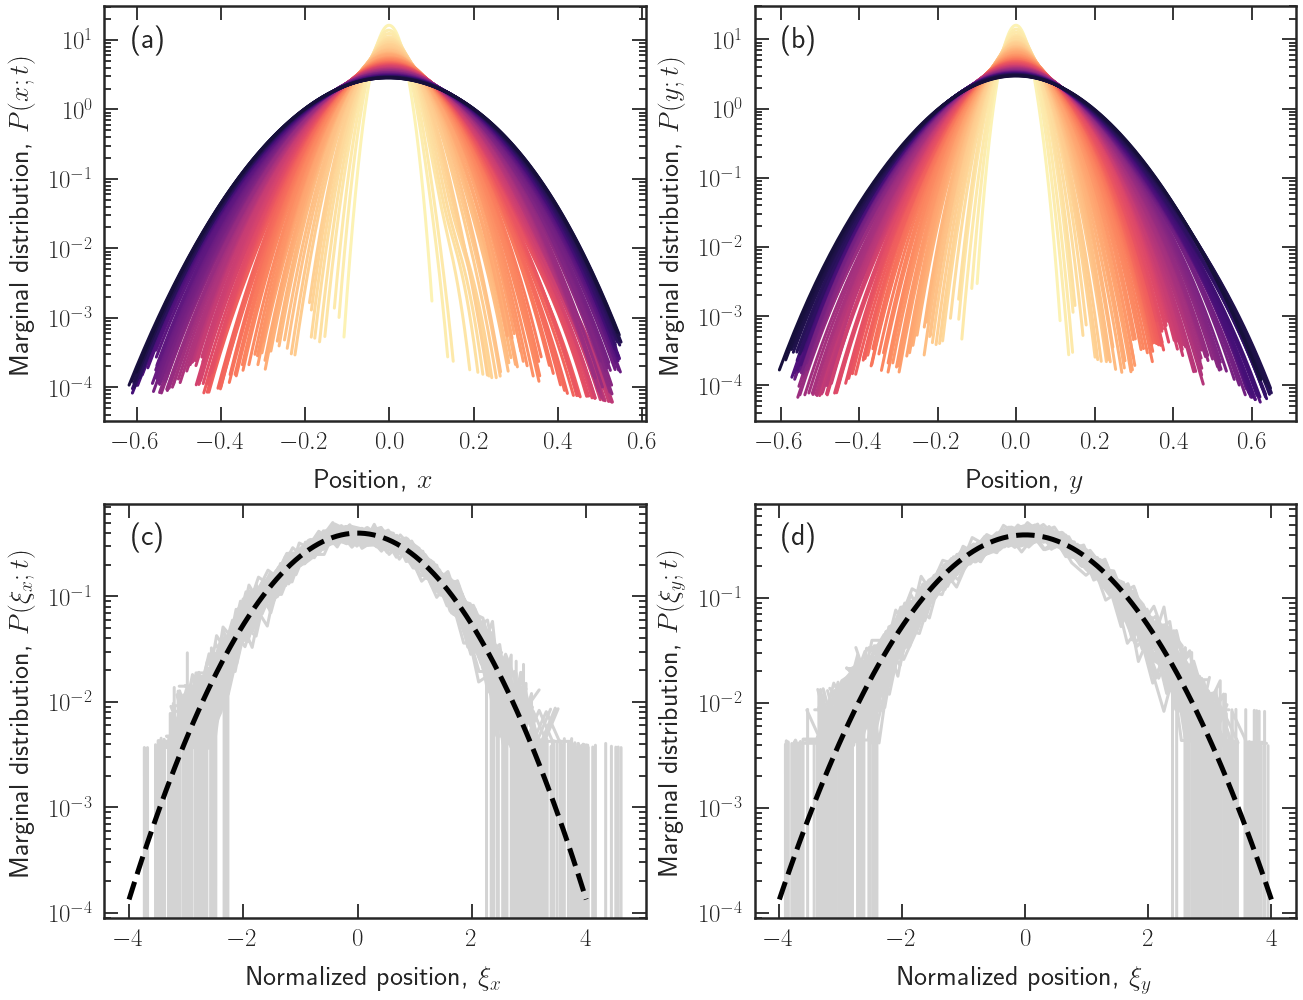

In [27]:
t_interval=10
t_min=30
t_max=1000
bw=1
colormap = plt.cm.magma_r
colors=[colormap(i) for i in np.linspace(0, 0.9,t_max)]

f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))

ax=axs.flatten()[0]
for t in range(t_min,t_max,t_interval):
    sns.kdeplot(x_plane[::,t],ax=ax,color=colors[t],linewidth=3,bw=bw)

ax.set_yscale('log')
ax.set_xlabel(r'Position, $x$')
ax.set_ylabel(r'Marginal distribution, $P(x;t)$')

ax=axs.flatten()[1]
   
for t in range(t_min,t_max,t_interval):
    sns.kdeplot(y_plane[::,t],ax=ax,color=colors[t],linewidth=3,bw=bw)
    
ax.set_yscale('log')
ax.set_xlabel(r'Position, $y$')
ax.set_ylabel(r'Marginal distribution, $P(y;t)$')

ax=axs.flatten()[2]
   
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_x[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)

r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r, 0, 1),'k--')

ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_x$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_x;t)$')

ax=axs.flatten()[3]
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_y[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)


r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r,0,1),'k--')
ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_y$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_y;t)$')

label_panels(axs)
f.tight_layout()


In [30]:
# pip install watermark

In [31]:
import watermark
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Apr 08 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.2.0

path       : 16.4.0
statsmodels: 0.13.2
numpy      : 1.22.3
scipy      : 1.8.0
matplotlib : 3.5.1
seaborn    : 0.11.2
pandas     : 1.4.2
watermark  : 2.3.0
palettable : 3.3.0
sys        : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:45:10) [Clang 12.0.1 ]

Watermark: 2.3.0

